## Project Predictive Analytics: New York City Taxi Ride Duration Prediction

## ****
---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on. A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip. Here the data set contains various information regarding the taxi trips, its duration in New York City. We will apply different techniques here to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended



### We will do the following steps:
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system

#### Uncomment the code given below, and run the line of code to install featuretools library

In [ ]:
# Uncomment the code given below, and run the line of code to install featuretools library

#!pip install featuretools==0.27.0

### Note: If !pip install featuretools doesn't work, please install using the anaconda prompt by typing the following command in anaconda prompt
      conda install -c conda-forge featuretools==0.27.0

In [2]:
!pip install featuretools

### Feataurestools for feature engineering

In [22]:
import featuretools as ft

### Importing libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

1.4.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# set global random seed
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### Load the Datasets

In [25]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
649598,679634,1,2016-04-30 11:45:59,2016-04-30 11:47:47,1,0.50,-73.994919,40.755226,-74.000351,40.747917,1,108.0,D,AG
649599,679635,2,2016-04-30 11:46:04,2016-04-30 11:47:41,2,0.33,-73.978935,40.777172,-73.981888,40.773136,2,97.0,AV,AV
649600,679636,2,2016-04-30 11:46:39,2016-04-30 11:58:02,1,1.78,-73.998207,40.745201,-73.990265,40.729023,2,683.0,AP,H
649601,679637,2,2016-04-30 11:46:44,2016-04-30 11:55:42,1,1.40,-73.987129,40.739429,-74.007370,40.743511,2,538.0,R,Q
649602,679638,2,2016-04-30 11:47:30,2016-04-30 11:54:00,1,1.12,-73.942375,40.790768,-73.952095,40.777145,2,390.0,J,AM
649603,679639,1,2016-04-30 11:47:38,2016-04-30 11:57:22,2,1.90,-73.960800,40.769920,-73.978966,40.785698,1,584.0,K,I
649604,679640,1,2016-04-30 11:47:49,2016-04-30 12:01:05,1,4.30,-74.013885,40.709515,-73.987213,40.722343,2,796.0,AU,AC
649605,679641,1,2016-04-30 11:48:17,2016-04-30 12:01:02,1,2.90,-73.975426,40.757584,-73.999016,40.722027,1,765.0,A,X
649606,679642,1,2016-04-30 11:49:44,2016-04-30 12:00:03,1,1.30,-73.989815,40.750454,-74.000473,40.762352,2,619.0,D,P


### Display first five rows

In [26]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


### Display info of the dataset

In [27]:
#checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974409 entries, 0 to 974408
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    974409 non-null  int64         
 1   vendor_id             974409 non-null  category      
 2   pickup_datetime       974409 non-null  datetime64[ns]
 3   dropoff_datetime      974409 non-null  datetime64[ns]
 4   passenger_count       974409 non-null  int64         
 5   trip_distance         974409 non-null  float64       
 6   pickup_longitude      974409 non-null  float64       
 7   pickup_latitude       974409 non-null  float64       
 8   dropoff_longitude     974409 non-null  float64       
 9   dropoff_latitude      974409 non-null  float64       
 10  payment_type          974409 non-null  object        
 11  trip_duration         974409 non-null  float64       
 12  pickup_neighborhood   974409 non-null  object        
 13 

- There are 974409 non null values in the dataset

### Check the number of unique values in the dataset.

In [1]:
# Check the uniques values in each columns
trips.nunique()

NameError: name 'trips' is not defined


- vendor_id has only 2 unique values, implies there are only 2 Major taxi Vendors are there. 
- Passenger count has 8 unique values and payment type have 4 unique values. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

In [29]:
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,974409.0,509622.259282,294491.646773,0.000000,254521.000000,509310.000000,764743.000000,1.020002e+06
passenger_count,974409.0,1.664010,1.314975,0.000000,1.000000,1.000000,2.000000,9.000000e+00
trip_distance,974409.0,2.734356,3.307038,0.000000,1.000000,1.640000,2.990000,5.028000e+02
pickup_longitude,974409.0,-73.973275,0.035702,-74.029846,-73.991058,-73.981178,-73.966888,-7.377051e+01
pickup_latitude,974409.0,40.752475,0.026668,40.630268,40.739689,40.755390,40.768929,4.084991e+01
dropoff_longitude,974409.0,-73.972825,0.031348,-74.029945,-73.990356,-73.979156,-73.962769,-7.377002e+01
dropoff_latitude,974409.0,40.753046,0.029151,40.630009,40.738792,40.755650,40.770454,4.085000e+01
trip_duration,974409.0,797.702753,576.802176,0.000000,389.000000,646.000000,1040.000000,3.606000e+03


In [14]:
trips['trip_distance'].max()

502.8

In [15]:
trips['trip_duration'].max()

3606.0

**Write your answers here:

The median and 75% of the passenger count is 1 and  2 respectively.

Average trip distance is 2.73miles, with a maximum value of 502.8 miles and minimum for trip distance is 0 miles.

 Average trip duration is 797.703 sec with a maximum duration of 3606 secs and minimum of 0 seconds. 
 
 
**

#### Checking for the rows for which trip_distance is 0

In [30]:
#Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD



- We can observe that, where trip_distance is 0, trip_duration may or may not be 0, hence we need to confirm if the trip duration is also 0 for some rows, then we will get rid of those rows and fill the rest trip_distance  with their Median values. 
- There are 3807 such rows with trip distance ==0

In [31]:
trips[(trips['trip_distance']==0) & (trips['trip_duration']==0)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
142202,148598,1,2016-01-30 00:00:29,2016-01-30 00:00:29,1,0.0,-73.989578,40.743877,-73.989578,40.743877,2,0.0,AO,AO
186754,195171,1,2016-02-07 02:18:12,2016-02-07 02:18:12,1,0.0,-73.958992,40.774734,-73.958992,40.774734,2,0.0,O,O
244549,255510,1,2016-02-17 16:20:07,2016-02-17 16:20:07,1,0.0,-73.981049,40.761829,-73.981049,40.761829,3,0.0,A,A
247768,258883,2,2016-02-18 07:51:48,2016-02-18 07:51:48,1,0.0,-73.950653,40.779415,-73.924385,40.744076,2,0.0,AM,L
453550,474136,2,2016-03-25 22:16:55,2016-03-25 22:16:55,1,0.0,-73.936821,40.764652,-73.936829,40.764648,1,0.0,AM,AM
510434,533535,1,2016-04-05 10:42:08,2016-04-05 10:42:08,1,0.0,-73.918495,40.743378,-73.918495,40.743378,2,0.0,L,L
789029,825835,2,2016-05-25 16:59:13,2016-05-25 16:59:13,2,0.0,-73.789581,40.646870,-73.957977,40.773521,1,0.0,G,O


In [32]:
len(trips[(trips['trip_distance']==0) & (trips['trip_duration']==0)])

7

In [33]:
## there are 7 rows with trip_distance and trip_duration with 0 values , hence we can safely remove those rows

In [34]:
trips = trips.loc[~((trips['trip_distance'] == 0) & (trips['trip_duration'] == 0)),:]

In [35]:
trips.shape

(974402, 14)

In [36]:
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972967,1018490,1,2016-06-30 19:09:44,2016-06-30 19:22:21,1,0.0,-73.945480,40.751400,-73.945496,40.751549,2,757.0,AN,AN
973384,1018928,2,2016-06-30 20:35:08,2016-06-30 20:35:10,1,0.0,-73.983864,40.693813,-73.983910,40.693817,1,2.0,AS,AS
973555,1019105,2,2016-06-30 21:13:50,2016-06-30 21:14:05,1,0.0,-74.008789,40.708740,-74.008659,40.708858,1,15.0,AU,AU
973607,1019159,2,2016-06-30 21:24:23,2016-06-30 21:37:40,1,0.0,-73.974510,40.778297,-73.977272,40.754047,1,797.0,I,AD


#### Replacing the 0 values with median of the trip distance

In [37]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [38]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

## we have removed those rows with both trip_distance and trip_distance r '0'

In [40]:
trips[(trips['trip_distance']==0) & (trips['trip_duration']==0)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood


#### Checking for the rows for which trip_duration is 0

In [41]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1,0.0,R,Z
172653,180414,1,2016-02-04 19:23:45,2016-02-04 19:23:45,1,0.40,-73.990868,40.751106,-73.990868,40.751106,2,0.0,D,D
173013,180795,1,2016-02-04 20:23:10,2016-02-04 20:23:10,1,0.80,-73.977661,40.752968,-73.977661,40.752968,2,0.0,AD,AD
217365,227235,2,2016-02-12 18:37:24,2016-02-12 18:37:24,1,19.10,-73.792397,40.656792,-73.973244,40.786911,2,0.0,G,I


In [42]:
trips[trips['trip_duration']==0].count()

id                      18
vendor_id               18
pickup_datetime         18
dropoff_datetime        18
passenger_count         18
trip_distance           18
pickup_longitude        18
pickup_latitude         18
dropoff_longitude       18
dropoff_latitude        18
payment_type            18
trip_duration           18
pickup_neighborhood     18
dropoff_neighborhood    18
dtype: int64


- We can observe that, where trip_duration is 0 trip_distance is not 0, hence we can replace those values. 

In [43]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [44]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

### Question 2: Univariate Analysis

### Question 2.1: Build histogram for numerical columns (1 Marks)

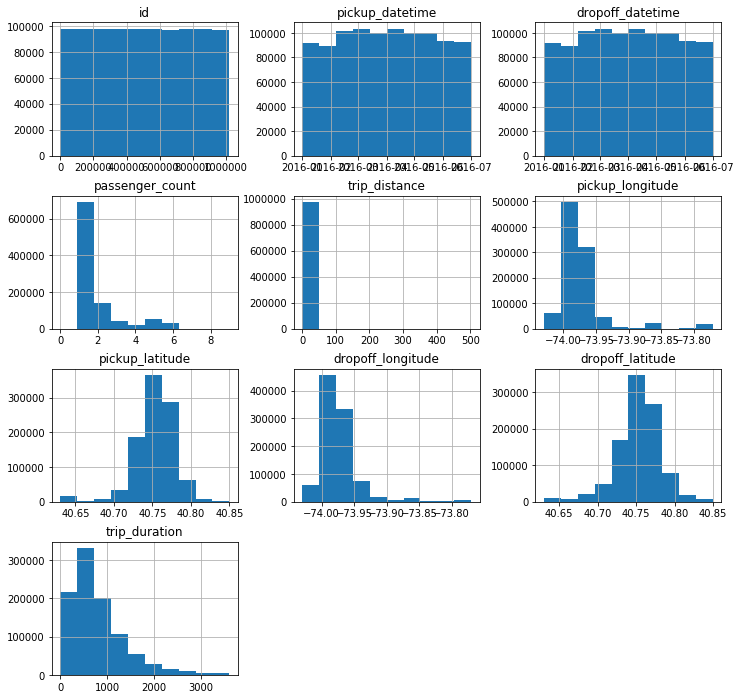

In [45]:
#Remove _________ and complete the code
trips.hist(figsize=(12,12))
plt.show()

**Write your answers here:
Pickup latitude, dropoff latitude are nearly normal distribution, while pickup longitude,dropoff longitude are a bit right skewed.

Trip_distance seem to have some outlier, which we can investigate through boxplot, most of the data resides under 3 to 5 miles.

trip duration is also rightly skewed.
**

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


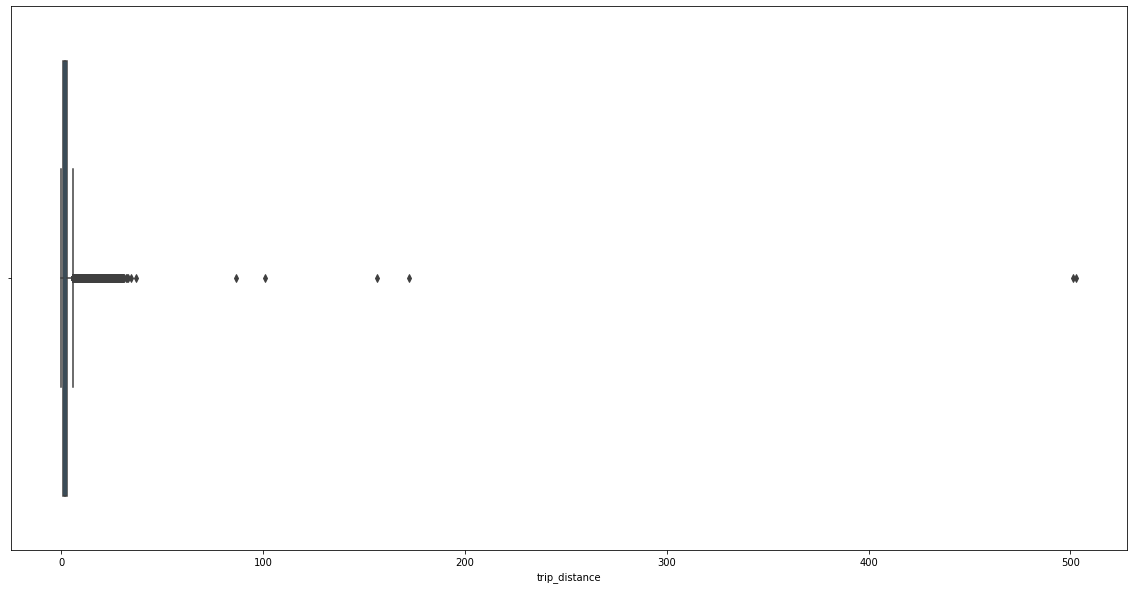

In [49]:
fig_dims = (20,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(trips['trip_distance'],ax=ax)
plt.show()

- We can see there is an extreme outlier in the trip_distance dataset, we drop investigate it further

In [51]:
trips[trips['trip_distance']>50]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.20,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.40,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
481495,503322,2,2016-03-31 08:44:09,2016-03-31 09:42:09,1,86.52,-73.788063,40.641548,-73.981201,40.782558,2,3480.0,G,I
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.30,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.80,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.00,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


In [52]:
trips[trips['trip_distance']>10]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
7,7,1,2016-01-01 00:05:06,2016-01-01 00:32:46,1,10.60,-73.972755,40.764198,-73.834953,40.692356,1,1660.0,A,T
14,14,1,2016-01-01 00:05:51,2016-01-01 00:20:22,1,12.10,-73.783302,40.648666,-73.873398,40.774208,2,871.0,G,F
25,25,1,2016-01-01 00:07:15,2016-01-01 00:37:42,1,10.40,-73.968987,40.753422,-73.854202,40.685101,2,1827.0,N,B
69,70,2,2016-01-01 00:14:46,2016-01-01 00:46:24,1,15.78,-73.978065,40.754677,-73.808937,40.786537,1,1898.0,AD,AQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974319,1019907,1,2016-06-30 23:41:50,2016-07-01 00:28:45,1,17.70,-73.788345,40.641762,-73.987335,40.749416,1,2815.0,G,AO
974364,1019956,2,2016-06-30 23:53:10,2016-07-01 00:34:31,1,13.42,-73.985168,40.759590,-74.021172,40.634369,2,2481.0,AA,M
974366,1019958,1,2016-06-30 23:53:16,2016-07-01 00:40:12,1,21.80,-73.791145,40.646000,-73.991989,40.767998,1,2816.0,G,P
974375,1019967,2,2016-06-30 23:54:40,2016-07-01 00:25:23,6,10.84,-73.778961,40.647430,-73.946762,40.652748,2,1843.0,G,AF


In [53]:
trips[trips['trip_distance']>3]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
7,7,1,2016-01-01 00:05:06,2016-01-01 00:32:46,1,10.60,-73.972755,40.764198,-73.834953,40.692356,1,1660.0,A,T
14,14,1,2016-01-01 00:05:51,2016-01-01 00:20:22,1,12.10,-73.783302,40.648666,-73.873398,40.774208,2,871.0,G,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974397,1019989,2,2016-06-30 23:57:28,2016-07-01 00:26:17,1,6.96,-74.005928,40.736038,-73.959930,40.813782,1,1729.0,Q,AH
974399,1019991,2,2016-06-30 23:58:01,2016-07-01 00:17:21,1,3.75,-73.991707,40.726372,-73.950737,40.693722,1,1160.0,H,AW
974400,1019992,2,2016-06-30 23:58:03,2016-07-01 00:38:50,1,5.88,-73.972687,40.677601,-73.976372,40.739632,2,2447.0,V,Y
974407,1020001,1,2016-06-30 23:59:30,2016-07-01 00:11:47,1,4.20,-74.017151,40.704884,-73.988228,40.723248,1,737.0,AU,AC


In [54]:
trips[trips['trip_distance']>5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
7,7,1,2016-01-01 00:05:06,2016-01-01 00:32:46,1,10.60,-73.972755,40.764198,-73.834953,40.692356,1,1660.0,A,T
14,14,1,2016-01-01 00:05:51,2016-01-01 00:20:22,1,12.10,-73.783302,40.648666,-73.873398,40.774208,2,871.0,G,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974393,1019985,2,2016-06-30 23:56:45,2016-07-01 00:41:28,1,8.05,-73.988205,40.753574,-73.899696,40.706509,1,2683.0,AA,E
974394,1019986,1,2016-06-30 23:57:13,2016-07-01 00:23:45,1,8.00,-73.963699,40.761166,-73.982407,40.692104,1,1592.0,AK,AS
974397,1019989,2,2016-06-30 23:57:28,2016-07-01 00:26:17,1,6.96,-74.005928,40.736038,-73.959930,40.813782,1,1729.0,Q,AH
974400,1019992,2,2016-06-30 23:58:03,2016-07-01 00:38:50,1,5.88,-73.972687,40.677601,-73.976372,40.739632,2,2447.0,V,Y


In [50]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
171143,178815,1,2016-02-04 14:05:10,2016-02-04 14:56:37,1,156.2,-73.979149,40.765499,-73.782806,40.644009,1,3087.0,AR,G
248346,259490,1,2016-02-18 09:48:06,2016-02-18 09:50:27,1,501.4,-73.980087,40.782185,-73.981468,40.778519,2,141.0,I,AV
525084,548884,1,2016-04-07 21:19:03,2016-04-07 22:03:17,3,172.3,-73.783340,40.644176,-73.936028,40.737762,2,2654.0,G,AN
530340,554389,1,2016-04-08 19:19:32,2016-04-08 19:41:33,2,502.8,-73.995461,40.724884,-73.986099,40.762108,1,1321.0,X,AA
828650,867217,1,2016-06-02 21:30:17,2016-06-02 21:36:47,2,101.0,-73.961586,40.800968,-73.950165,40.802193,2,390.0,AH,J


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

#### Clipping the outliers of trip distance to 50

In [55]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


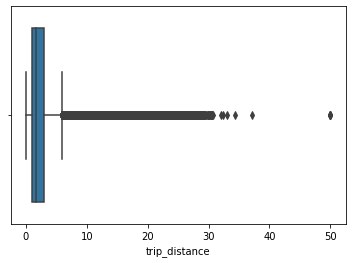

In [56]:
sns.boxplot(trips['trip_distance'])
plt.show()

In [57]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood


### Question 2.2 Plotting countplot for Passenger_count (1 Marks)

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


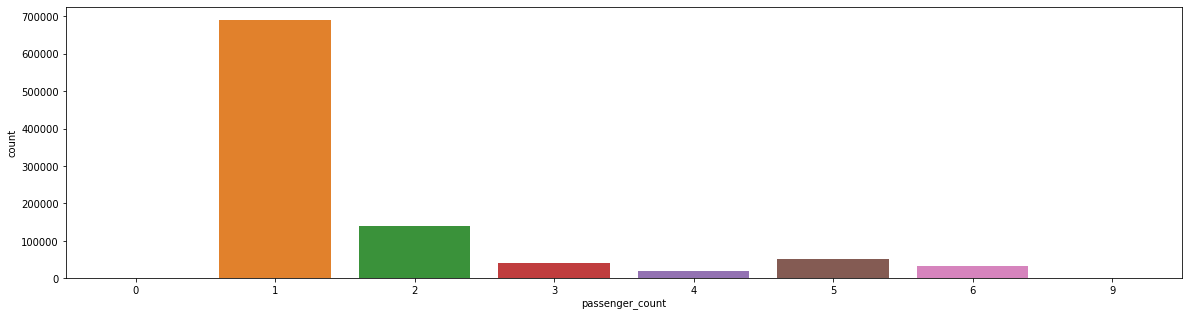

In [58]:


import seaborn as sns
plt.figure(figsize=(20,5))
sns.countplot(trips.passenger_count)
plt.show()

In [59]:
trips.passenger_count.value_counts(normalize=True)

1    0.709332
2    0.143419
5    0.053409
3    0.041140
6    0.033334
4    0.019338
0    0.000025
9    0.000002
Name: passenger_count, dtype: float64

**Write your answers here:

The distribution count for the "passenger_count" is different for different numbers, with highest distribution for passenger_count 1 = 71% .
for passenger_count 2 the distribution is = 14%.
**


### Question 2.3 Plotting countplot for pickup_neighborhood and dropoff_neighborhood (2 Marks)

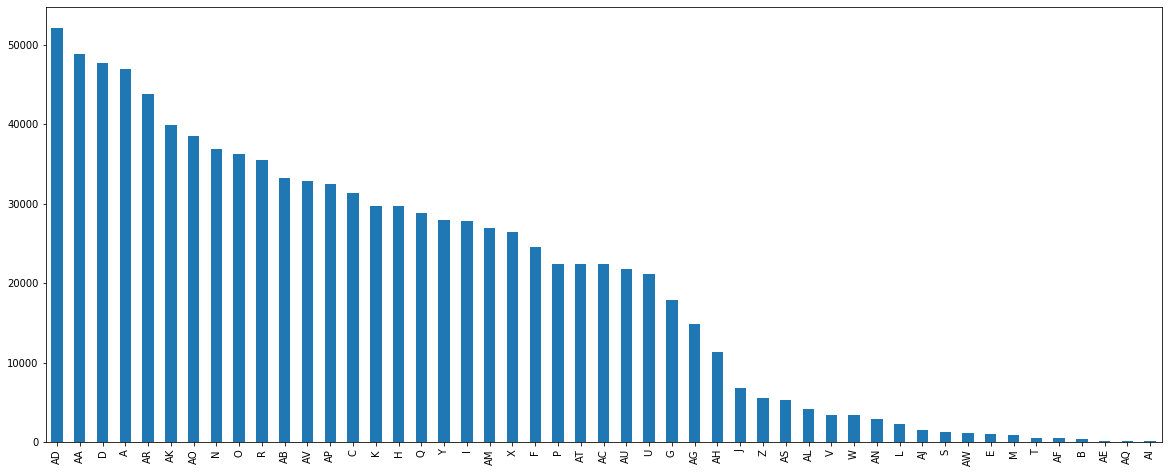

In [60]:

trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,8))

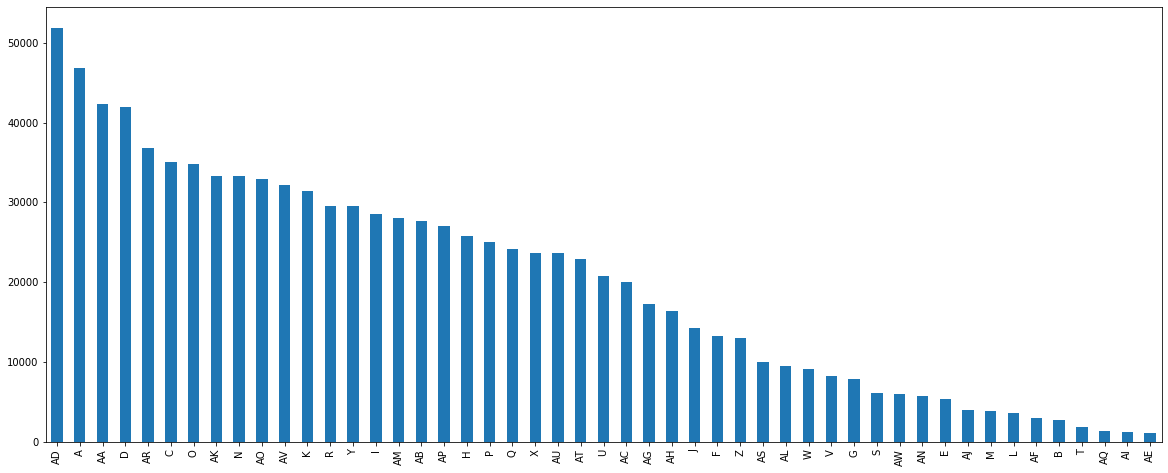

In [61]:


trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,8))

**Write your answers here:

-Most of the pickup and dropoff are from areas  :   AD,A,AA,D implies these are are the most "busy" in the city. 
- Areas like AQ,AI,AE ,T,B,AF are some areas from where very less number of pickups and dropoff are happening. 
**

In [62]:
pickup_neighborhoods.head()

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


### Bivariate analysis

#### Plot a scatter plot for trip distance and trip duration

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


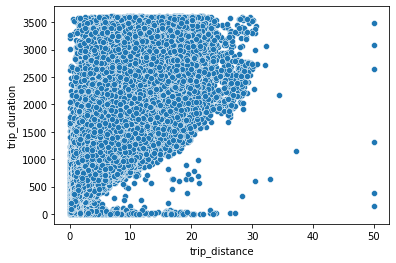

In [63]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration.

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


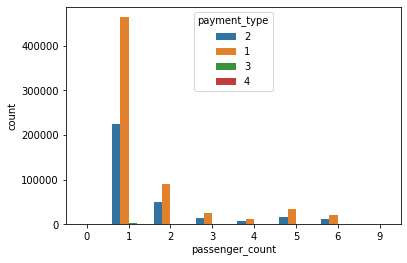

In [64]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

- There is a specific pattern that can be observed like most of the passengers (specially from the passenger_count=1 group) prefer to use payment_type=1.

### Step 2: Prepare the Data

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In <a <href="https://www.featuretools.com/"><featuretools (automated feature engineering software package)/></a>, we specify the list of entities and relationships as follows: 


### Question 3: Define entities and relationships for the Deep Feature Synthesis (2 Marks)

In [65]:


dataframes = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

In [ ]:
## I used dataframes instead of entities.....Found this change in the new version.

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after January 12th, 2016. 

In [66]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
667610,698425,2016-05-03 18:01:06
667611,698426,2016-05-03 18:01:11
667612,698427,2016-05-03 18:01:12
667613,698428,2016-05-03 18:01:12
667614,698429,2016-05-03 18:01:24
667615,698430,2016-05-03 18:01:36
667616,698431,2016-05-03 18:01:39
667617,698432,2016-05-03 18:01:41
667618,698433,2016-05-03 18:01:47


### Step 3: Create baseline features using Deep Feature Synthesis

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

### Question 4: Creating a baseline model with only 1 transform primitive (10 Marks)

**Question: 4.1 Define transform primitive for weekend and define features using dfs?** 

In [67]:

trans_primitives = [IsWeekend]


features = ft.dfs(dataframes=dataframes,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)



C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:362: UserWarning: Logical type Categorical for child column pickup_neighborhood does not match parent column neighborhood_id logical type Unknown. Changing child logical type to match parent.
  warnings.warn(f'Logical type {child_ltype} for child column {child_column} does not match '
C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:362: UserWarning: Logical type Categorical for child column dropoff_neighborhood does not match parent column neighborhood_id logical type Unknown. Changing child logical type to match parent.
  warnings.warn(f'Logical type {child_ltype} for child column {child_column} does not match '


## I have made necessary changes to the code to fit in the new version of featuretools.

## older version: given in the project

features = ft.dfs(entities=______________,
                  relationships=____________________,
                  target_entity="trips",
                  trans_primitives=_________________,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

## New version:
features = ft.dfs(dataframes=dataframes,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

*If you're interested about parameters to DFS such as `ignore_variables`, you can learn more about these parameters [here](https://docs.featuretools.com/generated/featuretools.dfs.html#featuretools.dfs)*
<p>Here are the features created.</p>

In [68]:
print ("Number of features: %d" % len(features))
features

Number of features: 11


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

**Question: 4.2 Compute features and define feature matrix**


## Older version:

def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

## Using New Version with few changes:

In [71]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,dataframes=dataframes, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [72]:

feature_matrix1 = compute_features(features, cutoff_time)

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:660: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn("A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: " + ", ".join(extra_params))
C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:660: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn("A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: " + ", ".join(extra_params))


Elapsed: 00:06 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [73]:
preview(feature_matrix1, 5)

,passenger_count,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,trip_distance,payment_type,trip_duration,pickup_neighborhoods.latitude,IS_WEEKEND(dropoff_datetime),dropoff_neighborhoods.longitude,vendor_id,IS_WEEKEND(pickup_datetime)
id,,,,,,,,,,,
56311,1,-73.987205,40.721435,1.61,1,645.0,40.720245,False,-73.998366,2,False
698425,1,-73.969822,40.793597,1.00,1,225.0,40.793597,False,-73.969822,1,False
698426,2,-73.956886,40.766809,0.70,2,372.0,40.766809,False,-73.956886,1,False
698427,1,-73.976515,40.682463,7.70,2,2725.0,40.752186,False,-73.974149,1,False
698428,2,-74.003458,40.761087,0.96,1,314.0,40.749843,False,-73.995736,2,False


In [74]:
feature_matrix1.shape

(920371, 11)

### Build the Model

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### Transforming the duration variable on sqrt and log

(array([  4566.,  35831., 163872., 249551., 225374., 149544.,  80472.,
         38481.,  18054.,   8657.]),
 array([ 1.        ,  6.90499792, 12.80999584, 18.71499376, 24.61999167,
        30.52498959, 36.42998751, 42.33498543, 48.23998335, 54.14498127,
        60.04997918]),
 <a list of 10 Patch objects>)

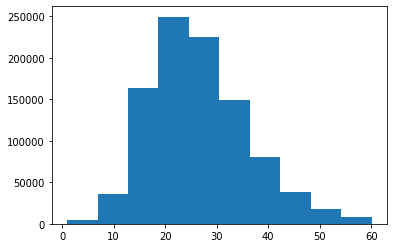

In [75]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([1.81000e+02, 5.97000e+02, 7.44000e+02, 1.43900e+03, 2.86700e+03,
        2.00260e+04, 1.35785e+05, 3.69731e+05, 3.50815e+05, 9.22170e+04]),
 array([0.        , 0.81903544, 1.63807088, 2.45710632, 3.27614176,
        4.0951772 , 4.91421264, 5.73324808, 6.55228352, 7.37131896,
        8.1903544 ]),
 <a list of 10 Patch objects>)

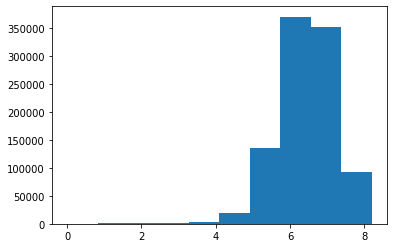

In [76]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

### Splitting the data into train and test

In [77]:
# separates the whole feature matrix into train data feature matrix, 
# train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

### Defining function for to check the performance of the model. 

In [78]:
#RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

#### Question 4.3 Build Linear regression using only weekend transform primitive

In [79]:
+

#defining the model

lr1=LinearRegression()

#fitting the model
lr1.fit(X_train,y_train)


LinearRegression()

#### Check the performance of the model

In [81]:

model_pref(lr1, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.569814  6.177546  4.781137
1   Test  0.547598  6.619296  5.080020


**Write your answers here:
Model is giving only 0.56 Rsquared for Train_set and 0.54 RSquared for Test_set, with Train_set RSME for of 6.177 and Train_set MAE of ~4.78.
- Model is performing better with no overfitting.

**

#### Question 4.4 Building decision tree using only weekend transform primitive

In [82]:


#define the model
dt=DecisionTreeRegressor()

#fit the model

dt.fit(X_train,y_train)

DecisionTreeRegressor()

#### Check the performance of the model

In [83]:

model_pref(dt, X_train, X_test,y_train,y_test)   

    Data  RSquared      RMSE       MAE
0  Train  0.917095  2.711937  1.517907
1   Test  0.598130  6.238678  4.635129


**Write your answers here:

- Model is giving 0.917 Rsquared for Train_set and 0.598 RSquared for Test_set.
- ==> Model is  Overfitting.
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

**


#### Question 4.5 Building Pruned decision tree using only weekend transform primitive

In [104]:

#define the model

#use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

#fit the model

dt_pruned.fit(X_train,y_train)


DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [105]:

model_pref(dt_pruned, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.733772  4.859756  3.708295
1   Test  0.703976  5.354433  4.050634


**Write your answers here:

The pruned model is performing better that both baseline decision tree and linear regression, with Test_set R2 as ~0.704.
**


#### Question 4.6 Building Random Forest using only weekend transform primitive

In [86]:


#define the model

#using (n_estimators=60,max_depth=7)

rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [88]:
#fit the model

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [89]:


model_pref(rf, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.738348  4.817816  3.675100
1   Test  0.708222  5.315893  4.019152


**Write your answers here:

The RSquared score for Test_set of the model with only 1 transform primitive is ~71 % vs RSquared score of Train_set = ~74%
- This model is performing a little better than pruned decision tree model.
-  Model is not much overfitting since not a big difference in their RSquared values.
_**


### Step 4: Adding more Transform Primitives and creating new model

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

### Question 5: Create models with more transform primitives (10 Marks)

**Question 5.1 Define more transform primitives and define features using dfs?**

## Since the new version of featuretools  doesnt recognize entities and ignore_variables, therefore i ll be doing necessary changes in the code:

## Older version:


trans_primitives = [_____________________________]


features = ft.dfs(entities=_________,
                  relationships=____________,
                  target_entity="trips",
                  trans_primitives=____________________,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

## New Version:

In [91]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(dataframes=dataframes,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:660: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn("A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: " + ", ".join(extra_params))
C:\Users\shehz\AppData\Local\Continuum\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:660: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn("A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: " + ", ".join(extra_params))


In [92]:
print ("Number of features: %d" % len(features))
features

Number of features: 21


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

**Question: 5.2 Compute features and define feature matrix**

In [93]:

feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:08 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [94]:
feature_matrix2.shape

(920371, 21)

In [95]:
feature_matrix2.head()

,pickup_neighborhoods.latitude,payment_type,HOUR(dropoff_datetime),WEEKDAY(pickup_datetime),MINUTE(dropoff_datetime),MONTH(pickup_datetime),pickup_neighborhoods.longitude,DAY(pickup_datetime),trip_distance,IS_WEEKEND(dropoff_datetime),...,dropoff_neighborhoods.longitude,MONTH(dropoff_datetime),passenger_count,vendor_id,HOUR(pickup_datetime),IS_WEEKEND(pickup_datetime),MINUTE(pickup_datetime),dropoff_neighborhoods.latitude,DAY(dropoff_datetime),trip_duration
id,,,,,,,,,,,,,,,,,,,,,
56311,40.720245,1,0,1,11,1,-73.987205,12,1.61,False,...,-73.998366,1,1,2,0,False,0,40.721435,12,645.0
56312,40.646194,2,0,1,23,1,-73.785073,12,16.15,False,...,-73.954298,1,1,2,0,False,2,40.715828,12,1270.0
56313,40.818445,1,0,1,5,1,-73.948046,12,0.80,False,...,-73.948046,1,1,1,0,False,2,40.818445,12,207.0
56314,40.729652,2,0,1,6,1,-73.991595,12,1.33,False,...,-73.977943,1,5,2,0,False,2,40.742531,12,214.0
56315,40.793597,1,0,1,13,1,-73.969822,12,2.35,False,...,-73.948046,1,1,2,0,False,3,40.818445,12,570.0


### Build the new models more transform features

In [96]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### Question 5.3 Building Linear regression using more transform primitive

In [97]:


#defining the model

lr2=LinearRegression()

#fitting the model

lr2.fit(X_train2,y_train2)




LinearRegression()

#### Check the performance of the model

In [98]:

model_pref(lr2, X_train2, X_test2,y_train2,y_test2) 

    Data  RSquared      RMSE       MAE
0  Train  0.618351  5.818625  4.306007
1   Test  0.617292  6.088122  4.582746


**Write your answers here:

- Model is giving 0.617 Rsquared for Train_set vs 0.618 RSquared for Test_set, with Test_set RSME of 6.08 and MAE of ~4.58.
- Model performance has improved from the last model by adding more transform primitives
- Model is not overfitting, and giving generalized results.
**

#### Question 5.4 Building Decision tree using more transform primitive

In [99]:


#define the model
dt2=DecisionTreeRegressor()

#fitting the model

dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

#### Check the performance of the model

In [100]:

model_pref(dt2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.708512  5.313244  3.814630


**Write your answers here:

- The model is overfitting a lot, with train_set R2 as 1 while test_set R2 as 0.708.
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves. 
_**

#### Question 5.5 Building Pruned Decision tree using more transform primitive

In [106]:

#define the model

#use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned2.fit(X_train2,y_train2)



DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [107]:

model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.768138  4.535263  3.423578
1   Test  0.745843  4.961356  3.697993


**Write your answers here:
- Model is giving ~0.77 Rsquared for Train_set and ~0.75 RSquared for Test_set, with Train_set RSME of 4.54 and MAE of 3.42 .
- Model performance has improved by adding more transform features. 
- Model is very slightly overfitting.
**

#### Question 5.6 Building Random Forest using more transform primitive

In [103]:
#fit the model


#using (n_estimators=60,max_depth=7)

rf2=RandomForestRegressor(n_estimators=60,max_depth=7)



rf2.fit(X_train2,y_train2)




RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [108]:

model_pref(rf2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.774825  4.469393  3.365776
1   Test  0.751916  4.901723  3.644405


**Write your answers here:


The RSquared score for Train_set for the model with more transform primitive is ~77% vs RSquared score of Test_set = ~75%.
As compared to previous model, the score has improved significantly.
**


**Question: 5.7 Comment on how the modeling accuracy differs when including more transform features.**

**Write your answers here:

After comparing the results from  all the models( Linear regression , Decision tree, Decision tree with pruning , Random forest), The results are very clear that the accuracy of all the models have improved as shown in the increase RSquared values.
R-squared evaluates the scatter of the data points around the fitted regression line. 
higher R-squared values represent smaller differences between the observed data and the fitted values.

==> the larger the R2, the better the model fits your observations.

**

### Step 5: Add Aggregation Primitives

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

### Question 6: Create a Models with transform and aggregate primitive. (10 Marks)
**6.1 Define more transform and aggregate primitive and define features using dfs?**

## Older version of Feature tools.. New Version Use dataframes instead of Entities, target_dataframe_name instead of target_entity, ignore_columns instead of ignore_variables...



trans_primitives = [____________]
aggregation_primitives = [____________________]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

## With New Version of Featuretools:

In [111]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(dataframes=dataframes,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [112]:
print ("Number of features: %d" % len(features))
features

Number of features: 59


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_duration)>,
 <Feature: pickup_

**Question: 6.2 Compute features and define feature matrix**

In [114]:

feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:17 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Finishing computing...


In [115]:
feature_matrix3.head()

,dropoff_neighborhoods.longitude,dropoff_neighborhoods.STD(trips.passenger_count),HOUR(pickup_datetime),MONTH(pickup_datetime),DAY(dropoff_datetime),dropoff_neighborhoods.MEDIAN(trips.trip_distance),MINUTE(pickup_datetime),dropoff_neighborhoods.MAX(trips.trip_duration),WEEKDAY(dropoff_datetime),pickup_neighborhoods.SUM(trips.passenger_count),...,dropoff_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.latitude,pickup_neighborhoods.MEAN(trips.trip_distance),dropoff_neighborhoods.MIN(trips.trip_distance),pickup_neighborhoods.COUNT(trips),trip_distance,pickup_neighborhoods.MEDIAN(trips.trip_duration),DAY(pickup_datetime),dropoff_neighborhoods.MAX(trips.passenger_count),trip_duration
id,,,,,,,,,,,,,,,,,,,,,
56311,-73.998366,1.303984,0,1,12,1.88,0,3572.0,1,2219.0,...,2.776637,40.721435,3.008243,0.05,1298,1.61,682.5,12,6.0,645.0
56312,-73.954298,1.335982,0,1,12,4.05,2,3526.0,1,2239.0,...,3.830819,40.715828,15.574504,0.18,1250,16.15,2086.0,12,6.0,1270.0
56313,-73.948046,1.289944,0,1,12,4.11,2,3312.0,1,390.0,...,3.705997,40.818445,2.868716,0.02,218,0.80,513.0,12,6.0,207.0
56314,-73.977943,1.375904,0,1,12,1.40,2,3581.0,1,2838.0,...,2.399295,40.742531,2.285250,0.01,1703,1.33,587.0,12,6.0,214.0
56315,-73.948046,1.289944,0,1,12,4.11,3,3312.0,1,1897.0,...,3.705997,40.818445,2.147041,0.02,1176,2.35,501.0,12,6.0,570.0


### Build the new models more transform and aggregate features

In [116]:
# separates the whole feature matrix into train data feature matrix,
# train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

#### Question 6.3 Building  Linear regression model with transform and aggregate primitive.

In [117]:


#defining the model

lr3=LinearRegression()

#fitting the model

lr3.fit(X_train3,y_train3)


LinearRegression()

#### Check the performance of the model

In [118]:

model_pref(lr3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.642833  5.628899  4.138410
1   Test  0.629418  5.990901  4.469302


**Write your answers here
:

- Model is giving only 0.64 Rsquared score for Train_set vs 0.63 Rsquared score for test_set , with Train_set RSME of 5.63 and MAE of ~4.14.
- Model is not overfitting, and giving generalized results. 
**

#### Question 6.4 Building  Decision tree with transform and aggregate primitive.

In [119]:


#define the model
dt3=DecisionTreeRegressor()

#fit the model

dt3.fit(X_train3,y_train3)





DecisionTreeRegressor()

#### Check the performance of the model

In [120]:

model_pref(dt3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.001479  0.000004
1   Test  0.650739  5.816005  4.191130


**Write your answers here:


- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.65
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.
**

#### Question 6.5 Building  Pruned Decision tree with transform and aggregate primitive.

In [121]:

#define the model

#use max_depth=7
dt_pruned3=DecisionTreeRegressor(max_depth=7)

#fit the model
dt_pruned3.fit(X_train3,y_train3)



DecisionTreeRegressor(max_depth=7)

#### Check the performance of the model

In [122]:

model_pref(dt_pruned3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.769246  4.524420  3.418271
1   Test  0.745721  4.962554  3.696065


**Write your answers here:
- Model is giving ~0.77 Rsquared for Train_set, with RSME of 4.52 and MAE of ~3.42.
- The model performance has slightly improved by adding aggregate primitives.
- Model is slightly overfitting. 
**


#### Question 6.6 Building  Random Forest with transform and aggregate primitive.

In [124]:
#fit the model

#using (n_estimators=60,max_depth=7)

rf3=RandomForestRegressor(n_estimators=60,max_depth=7)

#fit the model


rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### Check the performance of the model

In [125]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.776729  4.450455  3.353039
1   Test  0.753455  4.886499  3.631585


**Write your answers here:

- The model Performance has improved slightly to ~0.78( compared to 0.77 with only transform features)by the addition of transform and aggregation features.
- Model is not overfitting .
- The training time has also increased alot by a significant amount, implies that adding more features is always not very effective. 
**



**Question 6.7 How do these aggregate transforms impact performance? How do they impact training time?**

**Write your answers here:

After comparing the results from  all the models( Linear regression , Decision tree, Decision tree with pruning , Random forest), with new Transform and aggregate features, the results show that the accuracy of all the models have improved very little with lot of computation time..
.

**

#### Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3

In [126]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 215.84089913,  663.17928609,  242.04896286, ...,  180.01381529,
       1050.20868893, 1755.87932299])

### Question 7: What are some important features based on model2 and how can they affect the duration of the rides? (3 Marks)

In [128]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=15)

1: Feature: trip_distance, 0.910
2: Feature: HOUR(dropoff_datetime), 0.036
3: Feature: HOUR(pickup_datetime), 0.019
4: Feature: dropoff_neighborhoods.latitude, 0.016
5: Feature: WEEKDAY(dropoff_datetime), 0.003
6: Feature: pickup_neighborhoods.longitude, 0.003
7: Feature: IS_WEEKEND(pickup_datetime), 0.003
8: Feature: vendor_id, 0.003
9: Feature: IS_WEEKEND(dropoff_datetime), 0.002
10: Feature: WEEKDAY(pickup_datetime), 0.002
11: Feature: dropoff_neighborhoods.longitude, 0.001
12: Feature: pickup_neighborhoods.latitude, 0.000
13: Feature: payment_type, 0.000
14: Feature: MINUTE(dropoff_datetime), 0.000
15: Feature: MINUTE(pickup_datetime), 0.000


**Write your answers here:

 -Trip_Distance is the most important feature, which implies that the longer the trip is, the longer duration of the trip is.
 
- Features like dropoff_neighborhoods.longitude, pickup_neighborhoods.longitude dropoff_neighborhoods.latitude,signifies that trip duration is impacted by pickup and dropoff locations.

-Hour for pickup_datetime and dropoff_datetime also play important role in the 'trip_duration' value.

-Weekday dropoff and pickup datetime also play important role in defining the'trip_duration' value.

-Payment_type plays No role in defining the target variable(trip_duration).
**
